In [1]:
import random as rd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import MultipleLocator
from scipy import stats

In [24]:
# constants and initialization
item_threshold = 0 # 0 means no filtering
my_seed = 0
rd.seed(my_seed)
np.random.seed(my_seed)
predict_col = 'MOVIE_ID'
top_fraction = 0.2
user_events_file = 'movieratings.csv'
low_user_file = '10_niche_focused_users.txt'
medium_user_file = '10_diversed_focused_users.txt'
high_user_file = '10_blockbuster_focused_users.txt'

In [26]:
# read user events

df_events = pd.read_csv(user_events_file, sep=',', header=0)
df_uid_group = df_events.groupby('USER_MD5').count() >= 10
uid = df_uid_group[df_uid_group.MOVIE_ID].index
df_events = df_events[df_events.USER_MD5.isin(uid)]
print('No. of user events: ' + str(len(df_events)))

No. of user events: 1704946


In [27]:
# get user distribution
user_dist = df_events['USER_MD5'].value_counts()
num_users = len(user_dist)
print("Total number of users", num_users)
print('Mean number of movies rated by per user: ' + str(user_dist.mean()))
print('Min number of movies rated by per user: ' + str(user_dist.min()))
print('Max number of movies rated by per user: ' + str(user_dist.max()))

Total number of users 42980
Mean number of movies rated by per user: 39.6683573755235
Min number of movies rated by per user: 10
Max number of movies rated by per user: 2531


In [28]:
# get item distribution
item_dist = df_events[predict_col].value_counts()
num_items = len(item_dist)
print("Total number of moives:", num_items)

print('Mean number of ratings per movie has: ' + str(item_dist.mean()))
print('Min number of ratings per movie has: ' + str(item_dist.min()))
print('Max number of ratings per movie has: ' + str(item_dist.max()))

Total number of moives: 25569
Mean number of ratings per movie has: 66.68019867808674
Min number of ratings per movie has: 1
Max number of ratings per movie has: 274


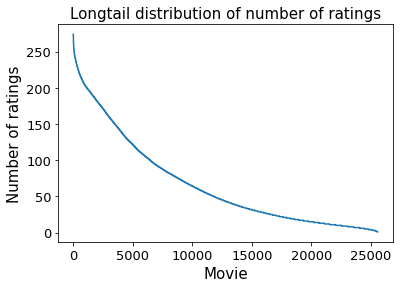

In [47]:
# plot item distribution
plt.figure()
plt.plot(item_dist.values)
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.ylabel('Number of ratings', fontsize='15')
plt.xlabel('Movie', fontsize='15')
plt.title("Longtail distribution of number of ratings", fontsize='15')
plt.show()

In [30]:
# get top items (20% as the top threshold)
num_top = int(top_fraction * num_items)
top_item_dist = item_dist[:num_top]
min_top_num = min(top_item_dist)
print('Min ratings of top movie:', min_top_num)
top_item_dist = item_dist[item_dist >= min_top_num]
len_top_num = len(top_item_dist)
print('No. top items: ' + str(len_top_num))


Min ratings of top movie: 120
No. top items: 5117


In [31]:
# read users
low_users = pd.read_csv(low_user_file, sep=',', header=None, index_col=0)
medium_users = pd.read_csv(medium_user_file, sep=',', header=None, index_col=0)
high_users = pd.read_csv(high_user_file, sep=',', header=None, index_col=0)
no_users = len(low_users) + len(medium_users) + len(high_users)
print('No. of users: ' + str(no_users))

No. of users: 44148


In [32]:
low_users["group"] = "low"
medium_users["group"] = "med"
high_users["group"] = "high"

user_all = pd.concat([low_users, medium_users, high_users])

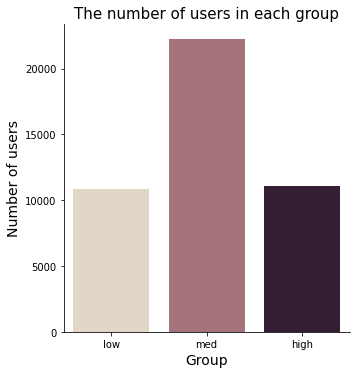

In [37]:
ax = sns.catplot(x="group", kind="count", palette="ch:.25", data=user_all)
plt.xlabel('Group', fontsize='14')
plt.ylabel('Number of users', fontsize='14')
plt.title("The number of users in each group", fontsize="15")
plt.show()

In [38]:
# get pop fractions
pop_count = [] # number of top items per user
user_hist = [] # user history sizes： number of all items per user (pop and not pop)
pop_fraq = [] # relative number of top items per user 每个用户评价流行电影占他评过电影的百分比
pop_item_fraq = [] # average popularity of items in user profiles
user_group = []
low_profile_size = 0
medium_profile_size = 0
high_profile_size = 0
low_gap = 0
medium_gap = 0
high_gap = 0
low_count = 0
med_count = 0
high_count = 0

low_user_pop_items = 0
medium_user_pop_items = 0
high_user_pop_items = 0

low_pop_ratio = 0
medium_pop_ratio = 0
high_pop_ratio = 0



for u, df in df_events.groupby('USER_MD5'):
    no_user_items = len(df[predict_col]) # profile size
    no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist.index)) # top items in profile

    # no_user_pop_items = len(set(df[predict_col]) & set(top_item_dist_2["MOVIE_ID"]))

    pop_count.append(no_user_pop_items)
    user_hist.append(no_user_items)
    pop_fraq_value = no_user_pop_items / no_user_items
    pop_fraq.append(pop_fraq_value)

    # get popularity (= fraction of users interacted with item) of user items and calculate average of it
    # df[predict_col]
    # item_dist[df[predict_col]])
    # no_users
    # no_user_items
    user_pop_item_fraq = sum(item_dist[df[predict_col]]) / no_users / no_user_items
    pop_item_fraq.append(user_pop_item_fraq)
    if u in low_users.index: # get user group-specific values
        low_profile_size += no_user_items
        low_gap += user_pop_item_fraq
        low_user_pop_items += no_user_pop_items
        low_pop_ratio += pop_fraq_value
        low_count += 1
        user_group.append("low")
    elif u in medium_users.index:
        medium_profile_size += no_user_items
        medium_gap += user_pop_item_fraq
        medium_user_pop_items += no_user_pop_items
        medium_pop_ratio += pop_fraq_value
        med_count += 1
        user_group.append("med")
    else:
        high_profile_size += no_user_items
        high_gap += user_pop_item_fraq
        high_user_pop_items += no_user_pop_items
        high_pop_ratio += pop_fraq_value
        high_count += 1
        user_group.append("high")

    # if pop_fraq_value == 0.0:
      #print(no_user_pop_items, no_user_items)
      #print(user_group[-1])
      #print()

low_profile_size_f = low_profile_size / low_count
medium_profile_size_f = medium_profile_size / med_count
high_profile_size_f = high_profile_size / high_count

low_user_pop_items_f = low_user_pop_items / low_count
medium_user_pop_items_f = medium_user_pop_items / med_count
high_user_pop_items_f = high_user_pop_items / high_count

low_pop_ratio_f = low_pop_ratio / low_count
medium_pop_ratio_f = medium_pop_ratio / med_count
high_pop_ratio_f = high_pop_ratio / high_count

low_gap /= len(low_users)
medium_gap /= len(medium_users)
high_gap /= len(high_users)

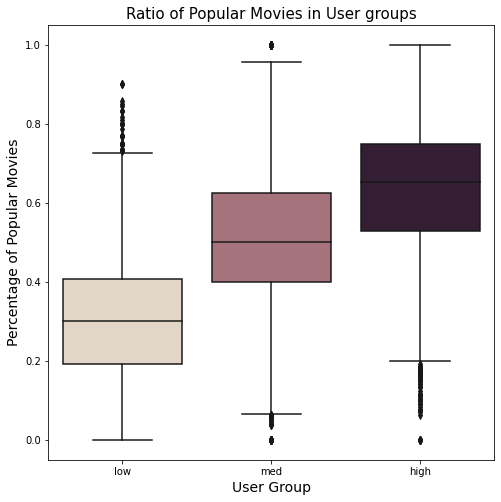

In [39]:
df_pop_user = pd.DataFrame({"pop_fraq" : pop_fraq, "user_group" : user_group}).sort_values("pop_fraq")

plt.figure(figsize=(8, 8))
sns.boxplot(x="user_group", y="pop_fraq", data=df_pop_user, palette="ch:.25", order=["low","med", "high" ])
plt.xlabel('User Group', fontsize='14')
plt.ylabel('Percentage of Popular Movies', fontsize='14')
plt.title("Ratio of Popular Movies in User groups", fontsize="15")
plt.show()

In [40]:
print(low_gap, medium_gap, high_gap)
print(low_pop_ratio_f, medium_pop_ratio_f, high_pop_ratio_f)
print(low_user_pop_items_f, medium_user_pop_items_f, high_user_pop_items_f)
print(low_profile_size_f, medium_profile_size_f, high_profile_size_f)

0.001982660096924439 0.002715235921407597 0.003147983748642222
0.30521537753533734 0.5091529958714991 0.6314442420561186
8.808620689655172 19.762029625540528 33.2387520829476
29.051436781609194 38.88747814886374 51.500925754489906


In [41]:
print('Low count (for check): ' + str(low_count))
print('Med count (for check): ' + str(med_count))
print('High count (for check): ' + str(high_count))

Low count (for check): 10440
Med count (for check): 21738
High count (for check): 10802


/Users/qian/opt/anaconda3/envs/tensorflow/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


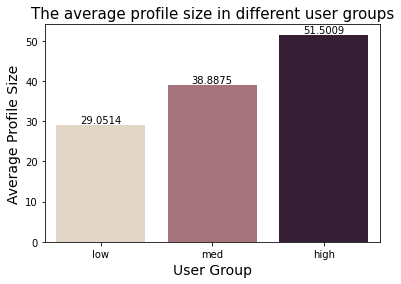

In [42]:
x = ['low','med','high']
y = [low_profile_size_f, medium_profile_size_f, high_profile_size_f]
ax = sns.barplot(x, y, palette="ch:.25")
plt.xlabel('User Group', fontsize='14')
plt.ylabel('Average Profile Size', fontsize='14')
plt.title("The average profile size in different user groups", fontsize="15")
ax.bar_label(ax.containers[0])
plt.show()

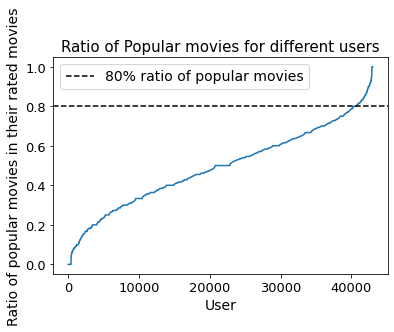

In [43]:
plt.figure()
plt.plot(sorted(pop_fraq))
plt.xlabel('User', fontsize='14')
plt.xticks(fontsize='13')
plt.ylabel('Ratio of popular movies in their rated movies', fontsize='14')
plt.yticks(fontsize='13')
plt.axhline(y=0.8, color='black', linestyle='--', label='80% ratio of popular movies')
plt.legend(fontsize='14')
plt.title("Ratio of Popular movies for different users", fontsize='15')
plt.show()

R-value: 0.9482871643197791


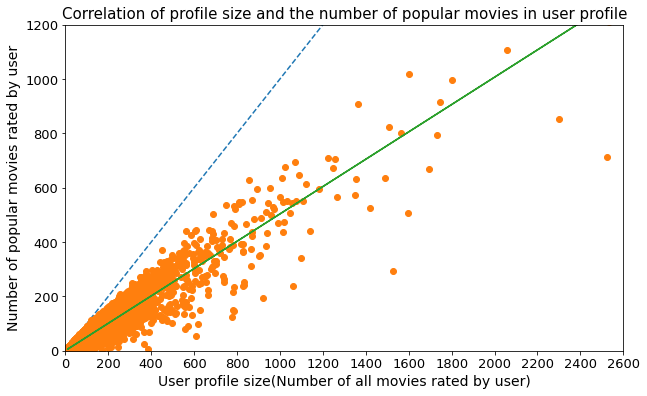

In [44]:
plt.figure(figsize=(10, 6))
# user_hist: number of all items per user (pop and not pop)
# pop_count: number of top items per user
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_count)
print('R-value: ' + str(r_value))
line = slope * np.array(user_hist) + intercept

x = list(range(1,2600))
plt.plot(x, x, '--', label="y=x")

plt.plot(user_hist, pop_count, 'o', user_hist, line)
plt.xlabel('User profile size(Number of all movies rated by user)', fontsize='14')
plt.xticks(fontsize='13')
plt.ylabel('Number of popular movies rated by user', fontsize='14')
plt.yticks(fontsize='13')

x_major_locator=MultipleLocator(200)
y_major_locator=MultipleLocator(200)
ax = plt.gca()
ax.xaxis.set_major_locator(x_major_locator)
ax.yaxis.set_major_locator(y_major_locator)
plt.xlim(0,2600)
plt.ylim(0,1200)
plt.title("Correlation of profile size and the number of popular movies in user profile",fontsize="15")
plt.show()

R-value: 0.0712817828687317
SpearmanrResult(correlation=0.178126435282891, pvalue=2.6420167908980603e-303)


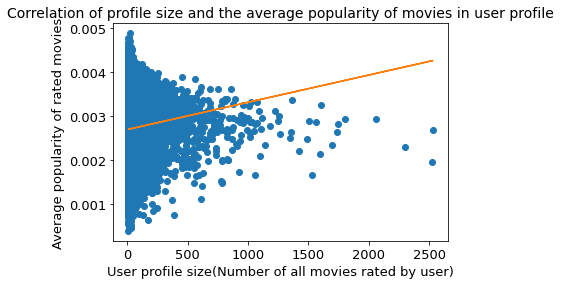

In [45]:
plt.figure()
# pop_item_fraq: average popularity of items in user profiles
slope, intercept, r_value, p_value, std_err = stats.linregress(user_hist, pop_item_fraq)
print('R-value: ' + str(r_value))
print(stats.spearmanr(user_hist, pop_item_fraq))
line = slope * np.array(user_hist) + intercept
plt.plot(user_hist, pop_item_fraq, 'o', user_hist, line)
plt.xlabel('User profile size(Number of all movies rated by user)', fontsize='13')
plt.ylabel('Average popularity of rated movies', fontsize='13')
plt.xticks(fontsize='13')
plt.yticks(fontsize='13')
plt.title("Correlation of profile size and the average popularity of movies in user profile",fontsize="14")
# 横坐标是评价的所有电影，纵坐标是评价过的pop电影的平均popularity度
plt.show()

In [46]:
print('Average LowMS profile size: ' + str(low_profile_size_f))
print('Average MedMS profile size: ' + str(medium_profile_size_f))
print('Average HighMS profile size: ' + str(high_profile_size_f))

Average LowMS profile size: 29.051436781609194
Average MedMS profile size: 38.88747814886374
Average HighMS profile size: 51.500925754489906
